# Simplest ETU4 model

4 _ \
3 _ \
2 _ \
1 _ _ b \
0 _ _ a\
...A S...


In [23]:
%matplotlib notebook
import matplotlib.pyplot as pl
from scipy import constants
import numpy as np
from sympy import init_session, solve, lambdify, Symbol, symbols, Eq
from sympy.physics.mechanics import dynamicsymbols
import sys
sys.path.append('../scripts/')
sys.path.append('../utils/')
from virtualab import Sample, Laser, Experiment
import utils

## Steady State

### Prepare sample

##### Unit cell: 

$NaY_{(1-x-y)}F_4:Yb_{x}Tm_{y}$

$Volume = \sqrt{3} / 2 a_h^2 c_h $ 

In [5]:
# Unit cell
x = 0.20
y = 0.01

# https://www.nature.com/articles/s41598-018-19415-w#citeas
ah = 5.91e-8 # cm
ch = 3.53e-8 # cm
vu = ah**2 * ch * 3**(0.5) / 2

# Density of states
NS = x / vu # Sensitizer
NA = y / vu # Activator

print(f'{NS=}, {NA=}')

NS=1.8730514061845395e+21, NA=9.365257030922697e+19


#### Energy states

$\vert{a} \rangle$ : Yb- $^2F_{7/2}$ \
$\vert{b} \rangle$ : Yb- $^2F_{5/2}$

$\vert{0} \rangle$ : Tm- $^3H_{6}$ \
$\vert{1} \rangle$ : Tm- $^3H_{5}$ - $^3F_{4}$ \
$\vert{2} \rangle$ : Tm- $^3F_{2,3}$ - $^3H_{4}$ \
$\vert{3} \rangle$ : Tm- $^1G_{4}$ \
$\vert{4} \rangle$ : Tm- $^1D_{2}$ 

In [223]:
# ET constants and decay rates

# Liu2013:
# sigma = 1.69e-20 # cm2 
# taub = 1.32e-3   # s 
# tau1 = 7.43e-3   # s 
# tau2 = 1.49e-3   # s 

w0 = 1.6e-18     # cm3/s 
# w1 = 6.2e-16     # cm3/s 
# w2 = 1.6e-18     # cm3/s 
# w3 = 1.6e-18     # cm3/s 

# Delgado2015
sigma = 1e-21    # cm2 
taub = 2.3e-3    # s 
tau1 = 12e-3     # s 
tau2 = 2e-3      # s 
tau3 = 675e-6    # s 
tau4 = 500e-6    # s 

# From measurements:
rho1 = 20000 # W/cm2
rho2 = 40 # W/cm2
rho3 = 80 # W/cm2

nu = constants.c / 976e-9
alpha = sigma / (constants.h * nu)
rb = 1 / taub
r1 = 1 / tau1
r2 = 1 / tau2
r3 = 1 / tau3
r4 = 1 / tau4

w1 = r1 * rb / (alpha * NS * rho1)
w2 = r2 * rb / (alpha * NS * rho2)
w3 = r3 * rb / (alpha * NS * rho3)
w4 = 0
print(f'{w1=}, {w2=}, {w3=}')

w1=1.9685123334417692e-19, w2=5.905537000325308e-16, w3=8.748943704185641e-16


#### Rate equations

In [224]:
Ri = ('NA', r1, r2, r3, r4)
Wi = (w0, w1, w2, w3, w4)
def rhoi(i):
    assert i > 0, 'rhob0 does not exist'
    return(
        Ri[i] * Rb / (Wi[i] * NS * alpha)
    )

def Nb(rho):
    return(NS * rho / (rho + rb / alpha))

def Na(rho):
    return(NS - Nb(rho))

def Ni(i, rho):
    if i==0:
        n0 = np.array(len(rho) * [NA])
        return(n0)
    ni = Ni(i-1, rho) * Wi[i-1] * Nb(rho) / (Wi[i] * Nb(rho) + Ri[i])
    return ni

def iQYi(i, rho):
    qyi = Ni(i, rho) / (alpha * rho * (NS - Nb(rho)))
    return qyi

In [225]:
power = np.logspace(-5, 3, 10000)

gsStr = lambda s: r'GS $\vert$'+ s +r'$\rangle$'
esStr = lambda s: r'ES $\vert$'+ s +r'$\rangle$'

<IPython.core.display.Javascript object>


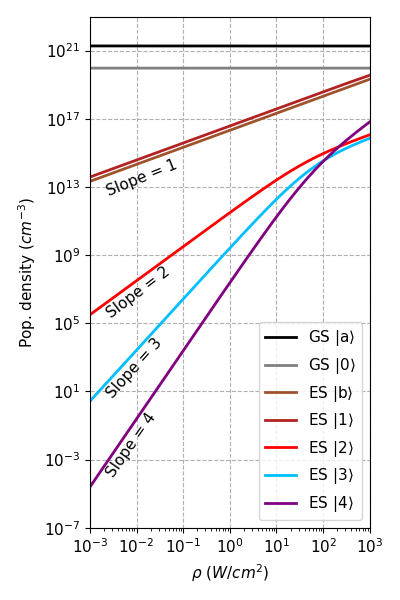

In [233]:
pl.rcParams.update({'font.size': 11})
fig, ax = pl.subplots(figsize=(4, 6))

ax.plot(power, Na(power), color='k', lw=2, label=gsStr('a'))

ax.loglog(power, Ni(0, power), lw=2, color='gray', label=gsStr('0'))

ax.loglog(power, Nb(power), color='sienna', lw=2, label=esStr('b'))
ax.text(2e-3, 3e12, 'Slope = 1', rotation=22)

ax.loglog(power, Ni(1, power), color='firebrick', lw=2, label=esStr('1'))
# ax.text(2e-3, 1e9, 'Slope = 1', rotation=22)

ax.loglog(power, Ni(2, power), color='red', lw=2, label=esStr('2'))
ax.text(2e-3,2e5, 'Slope = 2', rotation=37)

ax.loglog(power, Ni(3, power), color='deepskyblue', lw=2, label=esStr('3'))
ax.text(2e-3, 4, 'Slope = 3', rotation=48)

ax.loglog(power, Ni(4, power), color='purple', lw=2, label=esStr('4'))
ax.text(2e-3, 1e-4, 'Slope = 4', rotation=55)


ax.set_xlabel(r'$\rho$ $(W/cm^2)$')
ax.set_ylabel('Pop. density $(cm^{-3})$')
ax.set_xlim([1e-3, 10**3])
ax.set_ylim([1e-7, 1e23])

ax.grid(linestyle='--', linewidth=0.8)
ax.legend()
pl.tight_layout()

<IPython.core.display.Javascript object>


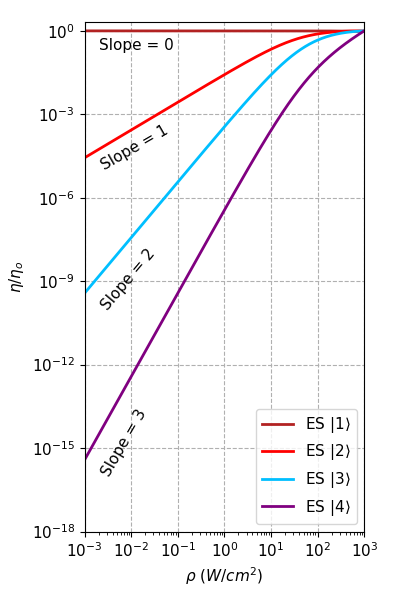

In [227]:
pl.rcParams.update({'font.size': 11})
fig, ax = pl.subplots(figsize=(4, 6))

ax.plot(power, iQYi(1, power) / max(iQYi(1, power)), color='firebrick', lw=2, label=esStr('1'))
ax.text(2e-3, 2e-1, 'Slope = 0', rotation=0)

ax.plot(power, iQYi(2, power) / max(iQYi(2, power)), color='red', lw=2, label=esStr('2'))
ax.text(2e-3, 1e-5, 'Slope = 1', rotation=30)

ax.plot(power, iQYi(3, power) / max(iQYi(3, power)), color='deepskyblue', lw=2, label=esStr('3'))
ax.text(2e-3, 9e-11, 'Slope = 2', rotation=50)

ax.plot(power, iQYi(4, power) / max(iQYi(4, power)), color='purple', lw=2, label=esStr('4'))
ax.text(2e-3, 1e-16, 'Slope = 3', rotation=60)


ax.set_xlabel(r'$\rho$ $(W/cm^2)$')
ax.set_ylabel('$\eta / \eta_o$')
ax.set_xlim([1e-3, 10**3])
ax.set_ylim([1e-18, 2])

ax.grid(linestyle='--', linewidth=0.8)
ax.legend()
pl.tight_layout()

### Beam profile compensation

In [273]:
# Gaussian beam
def gaussBeam(a, sigma, mu, x):
#     a = 1 / (sigma * (2 * np.pi) ** 0.5)
    g = a * np.exp(- ((x - mu) / sigma)**2 / 2)
    return(g)

<IPython.core.display.Javascript object>


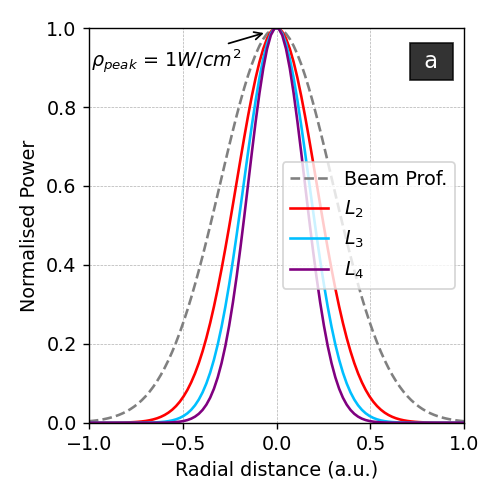

In [309]:
x = np.linspace(-1, 1, 100)
mu = 0
a = 1
std = 0.3

pl.rcParams.update({'font.size': 11})

fig, ax = pl.subplots(figsize=(4, 4))

arrowProps = dict(facecolor ='k', arrowstyle = "->")

ax.annotate(r'$\rho_{peak}$ = 1$W/cm^2$', xy=(-0.05, 0.99), xytext=(-0.99, 0.9), arrowprops = arrowProps)

axsLabel = ax.text(0.75, 0.9, ' a ', color='w', fontsize=13)
axsLabel.set_bbox(dict(facecolor='k', alpha=0.8, edgecolor='k'))


ax.plot(x, gaussBeam(1, std, mu ,x), '--', color='gray', label='Beam Prof.')
ax.plot(x, Ni(2, gaussBeam(a, std, mu ,x)) / max(Ni(2, gaussBeam(a, std, mu ,x))), color='red', label=r'$L_2$')
ax.plot(x, Ni(3, gaussBeam(a, std, mu ,x)) / max(Ni(3, gaussBeam(a, std, mu ,x))), color='deepskyblue', label=r'$L_3$')
ax.plot(x, Ni(4, gaussBeam(a, std, mu ,x)) / max(Ni(4, gaussBeam(a, std, mu ,x))), color='purple', label=r'$L_4$')

ax.legend()
ax.set_xlabel('Radial distance (a.u.)')
ax.set_ylabel(r'Normalised Power')
ax.grid(linestyle='--', linewidth=0.4)
ax.set_ylim([0,1])
ax.set_xlim([-1,1])

pl.tight_layout()

<IPython.core.display.Javascript object>


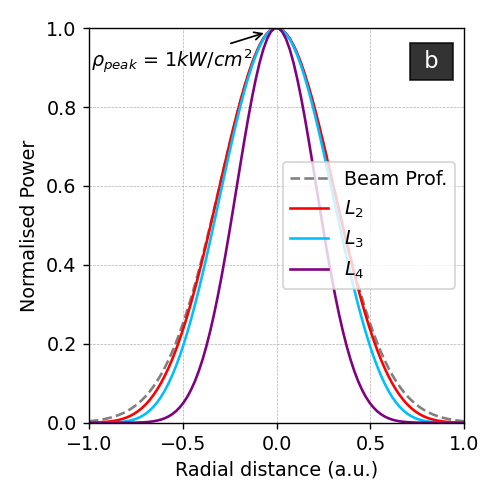

In [310]:
mu = 0
a = 1000
std = 0.3

pl.rcParams.update({'font.size': 11})

fig, ax = pl.subplots(figsize=(4, 4))

axsLabel = ax.text(0.75, 0.9, ' b ', color='w', fontsize=13)
axsLabel.set_bbox(dict(facecolor='k', alpha=0.8, edgecolor='k'))

ax.annotate(r'$\rho_{peak}$ = 1$kW/cm^2$', xy=(-0.05, 0.99), xytext=(-0.99, 0.9), arrowprops = arrowProps)

ax.plot(x, gaussBeam(1, std, mu ,x), '--', color='gray', label='Beam Prof.')
ax.plot(x, Ni(2, gaussBeam(a, std, mu ,x)) / max(Ni(2, gaussBeam(a, std, mu ,x))), color='red', label=r'$L_2$')
ax.plot(x, Ni(3, gaussBeam(a, std, mu ,x)) / max(Ni(3, gaussBeam(a, std, mu ,x))), color='deepskyblue', label=r'$L_3$')
ax.plot(x, Ni(4, gaussBeam(a, std, mu ,x)) / max(Ni(4, gaussBeam(a, std, mu ,x))), color='purple', label=r'$L_4$')

ax.legend(loc='center right')
ax.set_xlabel('Radial distance (a.u.)')
ax.set_ylabel(r'Normalised Power')
ax.grid(linestyle='--', linewidth=0.4)
ax.set_ylim([0,1])
ax.set_xlim([-1,1])

pl.tight_layout()

## Dynamics

### Create new experiment

In [83]:
experiment = Experiment()

### Prepare laser

In [129]:
# Laser ramp: 0 to 1000 W/cm^2
laser = Laser(wavelength=976e-9, mode='pulse')

# Constant average power
P_avg = 0.5 # W/cm^-2

# Pulse
Pp = 1 # W/cm^2
T = 0.2
Deltat = 0.1

laser.basePower = 0.0
laser.powerAtPeak = Pp  # W/cm^-2
laser.period = T
laser.periodOn = Deltat # delta t of duty cycle
laser.nCycles = 2
laser.samplingRate = 1e5 # number of points per second

### Prepare sample

In [130]:
sample = Sample(name='ETU4-simple-model')
# Population densities 
Na, Nb, N0, N1, N2, N3, N4 = dynamicsymbols("N_a N_b N_0 N_1 N_2 N_3 N_4")

# Total population
Nsens, Nact = symbols('N_sens N_act')
sample.props.update({Nsens: NS})
sample.props.update({Nact: NA})

# Energy transfer (W2 from experimental data)
W0, W1, W2, W3 = symbols('W_0 W_1 W_2 W_3')
sample.props.update({W0: w0}) # energy transfer upconversion rate in s^-1
sample.props.update({W1: w1}) # energy transfer upconversion rate in s^-1
sample.props.update({W2: w2}) # energy transfer upconversion rate in s^-1
sample.props.update({W3: w3}) # energy transfer upconversion rate in s^-1

# Decay rates (Delgado 2015)
Rba, R10, R20, R30, R40 = symbols('R_{ba} R_{10} R_{20} R_{30} R_{40}')
sample.props.update({Rba: rb}) # s^-1
sample.props.update({R10: r1}) # s^-1
sample.props.update({R20: r2}) # s^-1
sample.props.update({R30: r3}) # s^-1
sample.props.update({R40: r4}) # s^-1

# Cross section
sigmaab = symbols('sigma_ab')
sample.props.update({sigmaab: sigma}) # cm^-2

# constants
h, nu = symbols('h nu')
sample.props.update({h: constants.h}) # Planks constant
sample.props.update({nu: constants.c / laser.wavelength}) # frequency of excitation

# time
t = symbols('t')

# power density
p = symbols('rho')

# Rate equations
NaRate = Eq(Na.diff(t), Rba * Nb - sigmaab * p / (h * nu) * (Nsens - Nb))
NbRate = Eq(Nb.diff(t), - NaRate.rhs)

N0Rate = Eq(N0.diff(t), R40 * N4 + R30 * N3 + R20 * N2 + R10 * N1 - W0 * Nb * N0)
N1Rate = Eq(N1.diff(t), W0 * Nb * N0 - W1 * Nb * N1 - R10 * N1)
N2Rate = Eq(N2.diff(t), W1 * Nb * N1 - W2 * Nb * N2 - R20 * N2)
N3Rate = Eq(N3.diff(t), W2 * Nb * N2 - W3 * Nb * N3 - R30 * N3)
N4Rate = Eq(N4.diff(t), W3 * Nb * N3 - R40 * N4)

# Bind model to sample
sample.model([
    (Nb, NbRate, 0),
    (N0, N0Rate, sample.props[Nact]), 
    (N1, N1Rate, 0), 
    (N2, N2Rate, 0), 
    (N3, N3Rate, 0), 
    (N4, N4Rate, 0)
])
sample.boundaryConds = {
    Nb: [0, sample.props[Nsens]], 
    N0: [0, sample.props[Nact]], 
    N1: [0, sample.props[Nact]], 
    N2: [0, sample.props[Nact]], 
    N3: [0, sample.props[Nact]], 
    N4: [0, sample.props[Nact]]
}


In [131]:
# Rate equations used on the simulations
sample.showequations()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Run experiment

In [132]:
experiment.new(laser, sample)

Laser on 🚨: 100%|███████████████| 39999/39999 [44:04<00:00, 15.13it/s]


#### Add ground states 

In [133]:
# N_a
experiment.sample.data['N_a'] = experiment.sample.props[Nsens] - experiment.sample.data['N_b']

In [134]:
experiment.sample.data.loc[:5]

,t,power,N_b,N_0,N_1,N_2,N_3,N_4,N_a
0,0.00000,0.0,0.0,9.365257e+19,0.0,0.0,0.0,0.0,1.873051e+21
1,0.00001,0.0,0.0,9.365257e+19,0.0,0.0,0.0,0.0,1.873051e+21
2,0.00002,0.0,0.0,9.365257e+19,0.0,0.0,0.0,0.0,1.873051e+21
3,0.00003,0.0,0.0,9.365257e+19,0.0,0.0,0.0,0.0,1.873051e+21
4,0.00004,0.0,0.0,9.365257e+19,0.0,0.0,0.0,0.0,1.873051e+21
5,0.00005,0.0,0.0,9.365257e+19,0.0,0.0,0.0,0.0,1.873051e+21


<IPython.core.display.Javascript object>


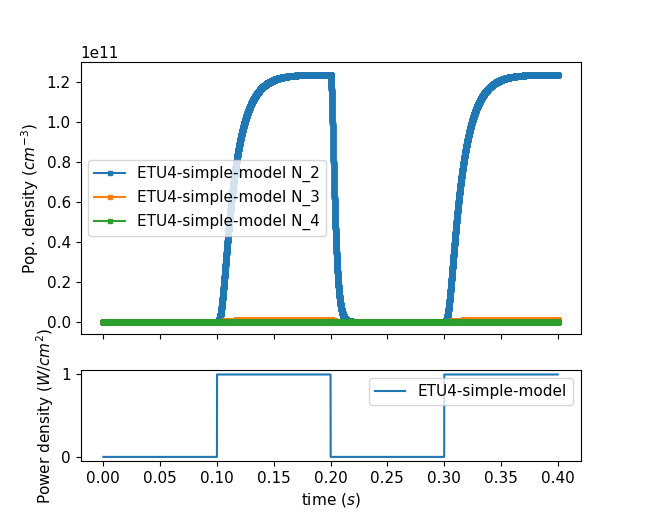

array([<AxesSubplot:ylabel='Pop. density ($cm^{-3}$)'>,
       <AxesSubplot:xlabel='time $(s)$', ylabel='Power density $(W/cm^2)$'>],
      dtype=object)

In [143]:
experiment.plot(x='t', yList=['N_2', 'N_3', 'N_4'])

In [144]:
experiment.save('simplest_etu4_pulsed')

Data saved: ..\output\simplest_etu4_pulsed.csv!


In [14]:
experiment.load('simplest_etu4_pulsed')

## Plots

<IPython.core.display.Javascript object>


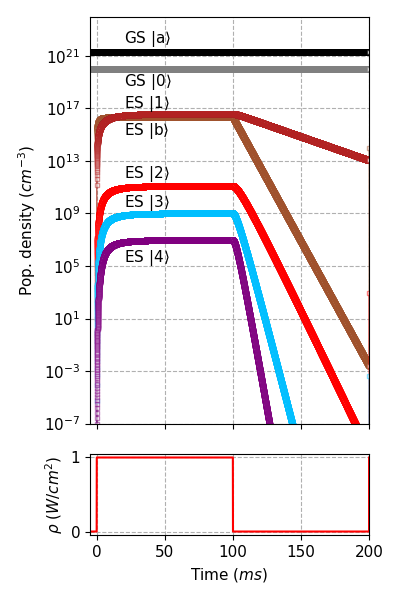

In [169]:
pl.rcParams.update({'font.size': 11})

fig, axs = pl.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [5, 1]}, figsize=(4, 6))

T = experiment.laser.period / 2
time = 1000 * (experiment.sample.data['t'] - T)
timeText = 20

axs[0].semilogy(time, experiment.sample.data['N_a'], '-s', color='k', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $a$')
axs[0].text(timeText, 1e22, gsStr('a'))
axs[0].semilogy(time, experiment.sample.data['N_0'], '-s', color='gray', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $0$')
axs[0].text(timeText, 5e18, gsStr('0'))

axs[0].semilogy(time, experiment.sample.data['N_b'], '-s', color='sienna', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $b$')
axs[0].text(timeText, 1e15, esStr('b'))

axs[0].semilogy(time, experiment.sample.data['N_1'], '-s', color='firebrick', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $1$')
axs[0].text(timeText, 1e17, esStr('1'))

axs[0].semilogy(time, experiment.sample.data['N_2'], '-s', color='red', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $2$')
axs[0].text(timeText, 5e11, esStr('2'))

axs[0].semilogy(time, experiment.sample.data['N_3'], '-s', color='deepskyblue', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $3$')
axs[0].text(timeText, 3e9, esStr('3'))

axs[0].semilogy(time, experiment.sample.data['N_4'], '-s', color='purple', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $3$')
axs[0].text(timeText, 2e5, esStr('4'))


axs[0].grid(linestyle='--', linewidth=0.8)
# axs[0].legend()

axs[0].set_ylabel('Pop. density $(cm^{-3})$')

axs[1].plot(time, experiment.sample.data['power'], '-', color='red', lw=1.5, label='Excitation pulse')
axs[1].set_xlabel('Time $(ms)$')
axs[1].set_ylabel(r'$\rho$ $(W/cm^2)$')
axs[1].grid(linestyle='--', linewidth=0.8)
# axs[1].legend()


axs[1].set_xlim([-5, 200])
axs[0].set_ylim([1e-7, 1e24])
pl.tight_layout()

<IPython.core.display.Javascript object>


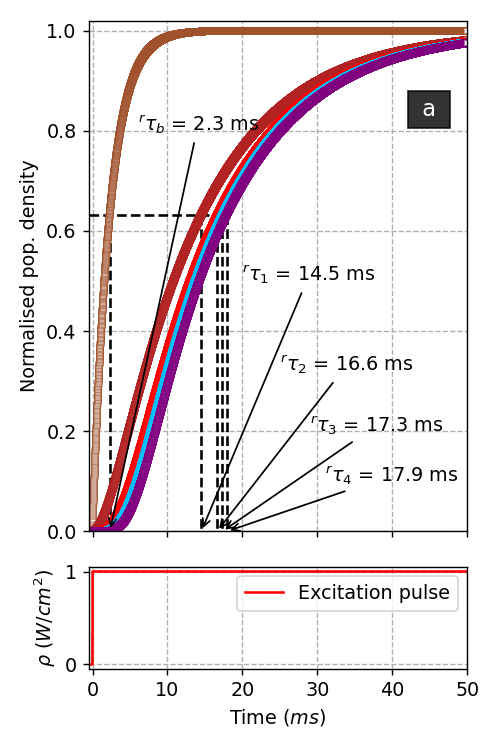

In [248]:
pl.rcParams.update({'font.size': 11})

fig, axs = pl.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [5, 1]}, figsize=(4, 6))

T = experiment.laser.period / 2
time = 1000 * (experiment.sample.data['t'] - T)
timeText = 20

arrowProps = dict(facecolor ='k', arrowstyle = "->")

axsLabel = axs[0].text(43, 0.83, ' a ', color='w', fontsize=13)
axsLabel.set_bbox(dict(facecolor='k', alpha=0.8, edgecolor='k'))

# # raise time
axs[0].plot([-0.5, 17.9], [1-np.exp(-1), 1-np.exp(-1)], 'k--')

axs[0].plot([14.5, 14.5], [1-np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^r\tau_1$ = 14.5 ms', xy=(14.5, 0), xytext=(20, 0.5), arrowprops = arrowProps)
axs[0].plot([16.6, 16.6], [1-np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^r\tau_2$ = 16.6 ms', xy=(16.6, 0), xytext=(25, 0.32), arrowprops = arrowProps)
axs[0].plot([17.3, 17.3], [1-np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^r\tau_3$ = 17.3 ms', xy=(17.3, 0), xytext=(29, 0.2), arrowprops = arrowProps)
axs[0].plot([17.9, 17.9], [1-np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^r\tau_{4}$ = 17.9 ms', xy=(17.9, 0), xytext=(31, 0.1), arrowprops = arrowProps)


axs[0].plot([2.3, 2.3], [1-np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^r\tau_{b}$ = 2.3 ms', xy=(2.3, 0), xytext=(6, 0.8), arrowprops = arrowProps)

axs[0].plot(time, experiment.sample.data['N_b'] / experiment.sample.data['N_b'].max(), '-s', color='sienna', ms=3, mfc='w', alpha=.5, lw=1, label=gsStr('b'))
# axs[0].text(timeText, 1e16, 'En. Level $b$')

axs[0].plot(time, experiment.sample.data['N_1'] / experiment.sample.data['N_1'].max(), '-s', color='firebrick', ms=3, mfc='w', alpha=.5, lw=1, label=esStr('1'))
# # axs[0].text(timeText, 1e13, 'En. Level $1$')

axs[0].plot(time, experiment.sample.data['N_2'] / experiment.sample.data['N_2'].max(), '-s', color='red', ms=3, mfc='w', alpha=.5, lw=1, label=esStr('2'))
# # axs[0].text(timeText, 1e10, 'En. Level $2$')

axs[0].plot(time, experiment.sample.data['N_3'] / experiment.sample.data['N_3'].max(), '-s', color='deepskyblue', ms=3, mfc='w', alpha=.5, lw=1, label=esStr('3'))
# # axs[0].text(timeText, 2e8, 'En. Level $3$')

axs[0].plot(time, experiment.sample.data['N_4'] / experiment.sample.data['N_4'].max(), '-s', color='purple', ms=3, mfc='w', alpha=.5, lw=1, label=esStr('4'))


axs[0].grid(linestyle='--', linewidth=0.8)
# axs[0].legend()

axs[0].set_ylabel('Normalised pop. density')

axs[1].plot(time, experiment.sample.data['power'], '-', color='red', lw=1.5, label='Excitation pulse')
axs[1].set_xlabel('Time $(ms)$')
axs[1].set_ylabel(r'$\rho$ $(W/cm^2)$')
axs[1].grid(linestyle='--', linewidth=0.8)
axs[1].legend()

pl.xlim([-0.5, 50])
axs[0].set_ylim([0, 1.02])
pl.tight_layout()

<IPython.core.display.Javascript object>


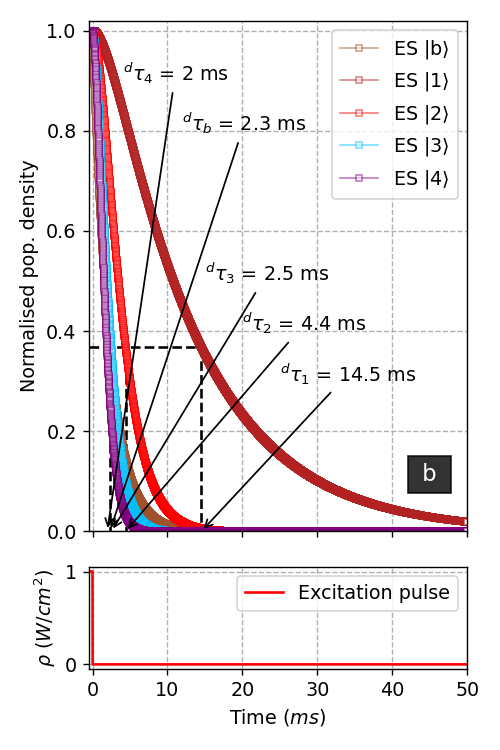

In [249]:
pl.rcParams.update({'font.size': 11})

fig, axs = pl.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [5, 1]}, figsize=(4, 6))

T = experiment.laser.period
time = 1000 * (experiment.sample.data['t'] - T)
timeText = 20

arrowProps = dict(facecolor ='k', arrowstyle = "->")

axsLabel = axs[0].text(43, 0.1, ' b ', color='w', fontsize=13)
axsLabel.set_bbox(dict(facecolor='k', alpha=0.8, edgecolor='k'))

# decay time
axs[0].plot([-0.5, 14.5], [np.exp(-1), np.exp(-1)], 'k--')

axs[0].plot([14.5, 14.5], [np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^d\tau_1$ = 14.5 ms', xy=(14.5, 0), xytext=(25, 0.3), arrowprops = arrowProps)
axs[0].plot([4.4, 4.4], [np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^d\tau_2$ = 4.4 ms', xy=(4.4, 0), xytext=(20, 0.4), arrowprops = arrowProps)
# axs[0].plot([2.52, 2.52], [np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^d\tau_3$ = 2.5 ms', xy=(2.52, 0), xytext=(15, 0.5), arrowprops = arrowProps)
# axs[0].plot([1.95, 1.95], [np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^d\tau_{4}$ = 2 ms', xy=(1.95, 0), xytext=(4, 0.9), arrowprops = arrowProps)


axs[0].plot([2.3, 2.3], [np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^d\tau_{b}$ = 2.3 ms', xy=(2.3, 0), xytext=(12, 0.8), arrowprops = arrowProps)




axs[0].plot(time, experiment.sample.data['N_b'] / experiment.sample.data['N_b'].max(), '-s', color='sienna', ms=3, mfc='w', alpha=.5, lw=1, label=esStr('b'))
# axs[0].text(timeText, 1e16, 'En. Level $b$')

axs[0].plot(time, experiment.sample.data['N_1'] / experiment.sample.data['N_1'].max(), '-s', color='firebrick', ms=3, mfc='w', alpha=.5, lw=1, label=esStr('1'))
# # axs[0].text(timeText, 1e13, 'En. Level $1$')

axs[0].plot(time, experiment.sample.data['N_2'] / experiment.sample.data['N_2'].max(), '-s', color='red', ms=3, mfc='w', alpha=.5, lw=1, label=esStr('2'))
# # axs[0].text(timeText, 1e10, 'En. Level $2$')

axs[0].plot(time, experiment.sample.data['N_3'] / experiment.sample.data['N_3'].max(), '-s', color='deepskyblue', ms=3, mfc='w', alpha=.5, lw=1, label=esStr('3'))
# # axs[0].text(timeText, 2e8, 'En. Level $3$')

axs[0].plot(time, experiment.sample.data['N_4'] / experiment.sample.data['N_4'].max(), '-s', color='purple', ms=3, mfc='w', alpha=.5, lw=1, label=esStr('4'))


axs[0].grid(linestyle='--', linewidth=0.8)
axs[0].legend()

axs[0].set_ylabel('Normalised pop. density')

axs[1].plot(time, experiment.sample.data['power'], '-', color='red', lw=1.5, label='Excitation pulse')
axs[1].set_xlabel('Time $(ms)$')
axs[1].set_ylabel(r'$\rho$ $(W/cm^2)$')
axs[1].grid(linestyle='--', linewidth=0.8)
axs[1].legend()

pl.xlim([-0.5, 50])
axs[0].set_ylim([0, 1.02])
pl.tight_layout()

In [236]:
np.exp(-1)

0.36787944117144233